# Introduction to Multi-Armed Bandits——03 Thompson Sampling[1]

## 参考资料

1. Slivkins A. Introduction to multi-armed bandits[J]. Foundations and Trends® in Machine Learning, 2019, 12(1-2): 1-286.

2. [Thompson Sampling](https://towardsdatascience.com/thompson-sampling-fc28817eacb8)

3. [WhatIThinkAbout/BabyRobot](https://github.com/WhatIThinkAbout/BabyRobot/tree/master/Multi_Armed_Bandits)

4. [在线学习(MAB)与强化学习(RL)[4]：贝叶斯Bandit算法](https://zhuanlan.zhihu.com/p/55254900)


## 一、 Greedy Decisions

在第二节中，介绍过贪心算法，其选择动作(`action`)的两个步骤为：

1. 从历史数据中估计一个模型

2. 选择对估计的模型来说是最优的动作。

![image-20230118153647817](https://note-image-1307786938.cos.ap-beijing.myqcloud.com/typora/%20image-20230118153647817.png)

贪心方法的一个缺点是它没有积极探索，这可能会降低性能。以Bernoulli bandit为例， `observation` 是 `reward`，所以 $r_t = r(y_t) = y_t$。 在每轮 $t$ ，将产生对每个 $k$ 个动作的平均奖励的估计值 $\hat{\theta}_k$，然后选择使这些估计值最大的动作。

我们再用具体的例子进行说明。假设有三个动作（臂），其平均奖励率为 $\theta \in \mathbb{R}^3$ 。 特别是，每次臂 $k$ 被选中，就会以 $\theta_k$ 的概率产生 $1$ 的奖励，否则奖励为0。 算法事先是不知道 $\theta$ 的值，需要不断观察样本去估计$\theta$。

下图为概率密度函数。这些分布代表了在智能体(agent)分别尝试了动作1和2一千次，动作3三次，获得了累计奖励分别为600、400和1，并将这些观察结果与每个动作的平均奖励的统一先验分布综合起来。智能体确信动作1和动作2的平均奖励接近于他们的期望值，即大约 $0.6$ 和 $0.4$ ，但是对动作3的平均奖励非常不确定。

![bernoulli_pdf](https://note-image-1307786938.cos.ap-beijing.myqcloud.com/typora/%20bernoulli_pdf.png)

因此，对于动作1和动作2我们已经得到了较多的数据，对其分布估计较为准确，所以从贪心的角度考虑，应该抛弃动作2，因为 $\theta_2 > \theta_1$ 的可能性极小。而由于动作3的数据较少，按理来说应该再尝试多几次，但是贪心算法不可能会这么做，**该算法没有考虑到到平均奖励的不确定性**。

`Dithering`(抖动)是一种常见的探索方法，它通过随机扰动动作来操作贪心算法。其中一个典型的算法就是 $Epsilon-greedy$ 算法，上一节说明过。尽管这种形式的探索相对于纯粹的贪心方法可以改善动作，但由于没有 "注销" 动作而浪费了资源。以上图为例，动作2几乎没有机会成为最优选择，因此不值得进行实验，而动作3的不确定性则值得探索。$Epsilon-greedy$ 探索将为每个动作分配同等数量的实验，会浪费掉许多实验。1933年提出的汤普森(`Thompson Sampling`)抽样提供了一个替代抖动的方法，可以更明智地分配探索。

## 二、Thompson Sampling for the Bernoulli Bandit

### 2.1 Beta-Bernoulli Bandit

假设有 $K$ 的动作，并且在执行时，任何动作都会成功或失败。当进行游戏时，动作 $k\in \{1,\cdots,K\}$ 产生一个概率为$\theta_k$的1奖励和一个概率为 $1-\theta_k$ 的零奖励。 动作 $k\in \{1,\cdots,K\}$ 成功的概率为 $\theta_k\in[0,1]$。成功概率$(\theta_1,...,\theta_K)$对智能体来说是未知的，但随着时间的推移是固定的，因此可以通过实验学习。在第一个阶段，一个动作 $x_1$ 被应用，奖励 $r_1 \in \{0,1\}$ 以成功概率 $\mathbb{P}(r_1=1 | x_1, \theta) = \theta_{x_1}$ 产生。 在观察到 $r_1$ 之后，算法应用另一个动作 $x_2$，观察到奖励 $r_2$ ，不断进行。

对于每个 $\theta_k$ 都有一个先验分布，在Beta-Bernoulli Bandit中，这些先验分布是 [beta 分布](https://baike.baidu.com/item/%E8%B4%9D%E5%A1%94%E5%88%86%E5%B8%83/8994021?fr=aladdin)。参数为 $\alpha = (\alpha_1,\ldots,\alpha_K)$ 和 $\beta \in (\beta_1,\ldots,\beta_K)$。对于每个动作 $k$ ，$\theta_k$ 先验概率密度函数为：

$$
p(\theta_k) = \frac{\Gamma(\alpha_k+\beta_k)}{\Gamma(\alpha_k)\Gamma(\beta_k)} \theta_k^{\alpha_k-1} (1-\theta_k)^{\beta_k-1}
$$

其中 $\Gamma$ 代表 gamma 函数。随着观察结果的收集，分布会根据贝叶斯规则进行更新。由于beta分布的共轭特性，用它来工作特别方便。特别是，每个动作的后验分布也是带有参数的 beta分布，可以根据一个简单的规则进行更新：

$$
\begin{aligned}
 (\alpha_k, \beta_k) &\leftarrow
 \begin{cases}
 	(\alpha_k, \beta_k)    & \text{if } x_t \neq k \\
 	(\alpha_k, \beta_k)+(r_t, 1-r_t)      & \text{if } x_t =k.
 \end{cases}
 \end{aligned}
$$

即如果我们选择了臂 $k$ ，如果得到奖励为1则将相应的 $\alpha_k$ +1( $\beta_k$ 不变)，否则将相应的 $\beta_k$ +1($\alpha_k$不变)。

对于$\alpha_k=\beta_k=1$的特殊情况，先验 $p(\theta_k)$ 在$[0,1]$上是均匀的。**只有选定的动作的参数被更新**。一个参数为$(\alpha_k,\beta_k)$ 的 β分布，其平均值为 $\alpha_k/(\alpha_k + \beta_k)$ , 随着 $\alpha_k+ β_k$ 的增长，分布变得更加集中。当 $\alpha_k$ 相较于 $\beta_k$ 比较大时，平均值比较大，图像右倾，反之左倾，如上图所示。动作1的分布是 $beta(601,401)$，动作2的分布是 $beta(401, 601)$，动作3的分布是 $beta(2, 3)$，也可以看出来动作3的试验次数较少。

## 2.2 算法思路

在Beta Bernoulli Bandit情形下，贪心算法的伪代码如下：

![image-20230118173647747](https://note-image-1307786938.cos.ap-beijing.myqcloud.com/typora/%20image-20230118173647747.png)

在每个时间段 $t$，算法产生一个估计值  $\hat{\theta}_k = \alpha_k/(\alpha_k+\beta_k)$，等于其当前对成功概率 $\theta_k$的期望。 然后，使$\hat{\theta}_k$ 最大的动作$x_t$被应用，在这之后得到奖励$r_t$，分布参数 $\alpha_{x_t}$和 $\beta_{x_t}$被更新。

我们再来看看汤普森抽样，其伪代码如下：

![image-20230118174258990](https://note-image-1307786938.cos.ap-beijing.myqcloud.com/typora/%20image-20230118174258990.png)

与贪心算法类似，唯一的区别是，**成功概率估计值 $\hat{\theta}_k$ 是从后验分布中随机抽取的，后验分布是一个参数为 $\alpha_k$ 和  $\beta_k$ 的 β分布，而不是取期望值$\alpha_k / (\alpha_k+\beta_k)$**。


让我们来看看汤普森采样是如何改进贪心算法的，回到之前三个臂的例子。在这种情况下，贪心算法将放弃学习动作3的潜在宝贵机会。在抖动(dithering)的情况下，尽管探索动作2几乎是徒劳无功的（因为动作2极不可能是最优的），但是探索动作2和3的机会是相等的。而汤普森采样算法会对动作1、2、3进行采样，其概率分别约等于 $0.82$ 、$0$ 和  $0.18$ 。 分别该动作抽取的随机估计值超过为其他动作抽取的估计值的概率，等于相应动作是最优的概率。 TS算法会天然同时完成`explore`和`exploit`，因为如果一个臂没怎么被选择，那么从这个臂中采样得到的 $\hat{\theta}_k$ 会以近似均匀的概率落在整个区间上（相当于uniform exploration）。而一个臂如果被选择的次数多了，那么自然估计的就比较准了，如果这个臂比较“好”，则从它的后验分布里采样出来的就有大概率是比较高的，这个臂也就比较容易会被`exploit`。


## 2.3 python实现与实验结果分析

首先实现两个智能体智能体(agent)——`BernoulliBanditEpsilonGreedy`和`BernoulliBanditTS`，其中epsilon-greedy的epsilon设置为0就为纯粹的贪心算法。两个智能体之间的区别只在`pick_action`方法的实现上。

In [4]:
import numpy as np


def random_argmax(vector):
    """选择vector中的最大值的下标，如果有多个最大，则随机选择其中一个"""
    index = np.random.choice(np.where(vector == vector.max())[0])
    return index


class BernoulliBanditEpsilonGreedy():
    """Bernoulli Bandit问题中使用ε-greedy算法"""

    def __init__(self, n_arm, a0=1, b0=1, epsilon=0.0):
        self.n_arm = n_arm
        self.epsilon = epsilon
        self.prior_success = np.array([a0 for arm in range(n_arm)])
        self.prior_failure = np.array([b0 for arm in range(n_arm)])

    def set_prior(self, prior_success, prior_failure):
        # 修改默认先验值
        self.prior_success = np.array(prior_success)
        self.prior_failure = np.array(prior_failure)

    def get_posterior_mean(self):
        # 由beta分布的α和β可知beta分布的期望为 α /(α+β)
        return self.prior_success / (self.prior_success + self.prior_failure)

    def get_posterior_sample(self):
        # 从后验抽样
        return np.random.beta(self.prior_success, self.prior_failure)

    def update_observation(self, observation, action, reward):
        # 简单检查与环境的兼容性
        assert observation == self.n_arm

        if np.isclose(reward, 1):
            self.prior_success[action] += 1
        elif np.isclose(reward, 0):
            self.prior_failure[action] += 1
        else:
            raise ValueError('Rewards should be 0 or 1 in Bernoulli Bandit')

    def pick_action(self, observation):
        if np.random.rand() < self.epsilon:
            # 随机探索
            action = np.random.randint(self.n_arm)
        else:
            # 从后验分布中选取一个均值最大的臂
            posterior_means = self.get_posterior_mean()
            action = random_argmax(posterior_means)

        return action


class BernoulliBanditTS(BernoulliBanditEpsilonGreedy):
    def pick_action(self, observation):
        """汤普森抽样"""
        sampled_means = self.get_posterior_sample()
        action = random_argmax(sampled_means)
        return action


然后实现环境(environment):

In [2]:
class BernoulliBandit():
  """Bernoulli Bandits"""

  def __init__(self, probs):
    """   
    probs: 每个臂的奖励概率
    optimal_reward: 最大奖励值
    n_arm: 臂的数目 
    """
    self.probs = np.array(probs)
    self.optimal_reward = np.max(self.probs)
    self.n_arm = len(self.probs)

  def get_observation(self):
    return self.n_arm

  def get_optimal_reward(self):
    return self.optimal_reward

  def get_expected_reward(self, action):
    return self.probs[action]

  def get_stochastic_reward(self, action):
    # 重复伯努利试验，产生0/1的奖励
    return np.random.binomial(1, self.probs[action])
  
  def advance(self, action, reward):
    """Updating the environment (useful for nonstationary bandit)."""
    pass

然后设计实验方法：

In [3]:
import numpy as np
import pandas as pd

class BaseExperiment(object):
  """基础实验：记录悔值(regret和采取的动作(action)
  """

  def __init__(self, agent, environment, n_steps,
               seed=0,  unique_id='NULL'):
    """
    agent: 智能体
    environment: 环境
    n_steps: 迭代次数
    seed: 随机数种子
    unique_id: 标识实验

    results: 实验结果

    """
    self.agent = agent
    self.environment = environment
    self.n_steps = n_steps
    self.seed = seed
    self.unique_id = unique_id

    self.results = []
    self.data_dict = {}


  def run_step_maybe_log(self, t):
    # 观察环境，选择臂
    observation = self.environment.get_observation()
    action = self.agent.pick_action(observation)

    # 计算有用的值
    optimal_reward = self.environment.get_optimal_reward()
    expected_reward = self.environment.get_expected_reward(action)
    reward = self.environment.get_stochastic_reward(action)

    # 使用获得的奖励和选择的臂更新智能体
    self.agent.update_observation(observation, action, reward)

    # 记录悔值
    instant_regret = optimal_reward - expected_reward
    self.cum_regret += instant_regret

    # 环境进化（非平稳实验中才会用到）
    self.environment.advance(action, reward)

    # 记录产生的数据
    self.data_dict = {'t': (t + 1),
                        'instant_regret': instant_regret,
                        'cum_regret': self.cum_regret,
                        'action': action,
                        'unique_id': self.unique_id}
    self.results.append(self.data_dict)


  def run_experiment(self):
    """运行实验，收集数据"""
    np.random.seed(self.seed)
    self.cum_regret = 0
    self.cum_optimal = 0

    for t in range(self.n_steps):
      self.run_step_maybe_log(t)

    # 使用pandas存储数据
    self.results = pd.DataFrame(self.results)


将TS算法与贪心算法的模拟结果进行比较。考虑一个三臂 beta-Bernoulli bandit，其平均奖励为 $\theta_1=0.9$, $\theta_2=0.8$, 以及 $\theta_3=0.7$。 让每个臂平均奖励的先验分布是均匀的（即`beta(1,1)`）。 下图绘制了基于每种算法的200次独立模拟的结果。每次模拟都是在一千个时间段内进行的。


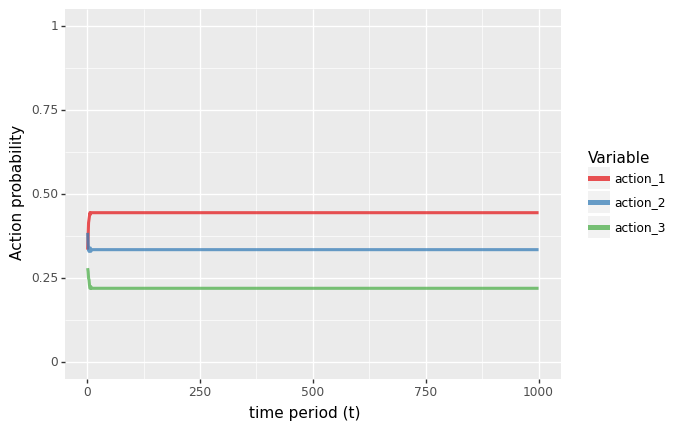

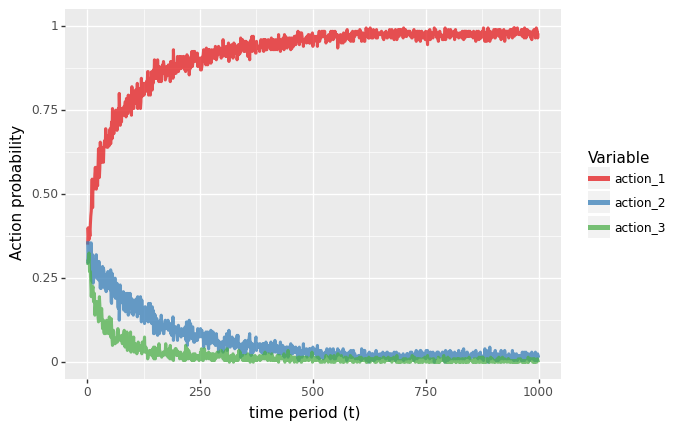

In [9]:
import plotnine as gg

def plotComparation(algorithm = 'TS'):
    probs = [0.9,0.8,0.7]
    n_steps = 1000
    N_JOBS = 200

    results = []
    for job_id in range(N_JOBS):
        if(algorithm == 'TS'):
            agent = BernoulliBanditTS(n_arm=len(probs))
        else:
            agent = BernoulliBanditEpsilonGreedy(n_arm=len(probs))
        env = BernoulliBandit(probs)
        experiment = BaseExperiment(
            agent, env, n_steps=n_steps, seed=job_id, unique_id=str(job_id))
        experiment.run_experiment()
        results.append(experiment.results)


    df_agent = pd.concat(results)


    n_action = np.max(df_agent.action) + 1
    plt_data = []
    for i in range(n_action):
        probs2 = (df_agent.groupby('t') # 按照t分组
                .agg({'action': lambda x: np.mean(x == i)}) # 按照action求平均
                .rename(columns={'action': 'action_' + str(i + 1)}))  # 重命名列
        plt_data.append(probs2)
    # 重置索引
    plt_df = pd.concat(plt_data, axis=1).reset_index()

    p = (gg.ggplot(pd.melt(plt_df, id_vars='t'))
        + gg.aes('t', 'value', colour='variable', group='variable')
        + gg.geom_line(size=1.25, alpha=0.75)
        + gg.xlab('time period (t)')
        + gg.ylab('Action probability')
        + gg.ylim(0, 1)
        + gg.scale_colour_brewer(name='Variable', type='qual', palette='Set1'))
    print(p)

plotComparation('Greedy')
plotComparation('TS')


而书中的试验次数达到了10000次，其结果如下：

![image-20230119220203199](https://note-image-1307786938.cos.ap-beijing.myqcloud.com/typora/%20image-20230119220203199.png)



从图中可以看到，贪心算法最后并非收敛到动作1，而是三个动作都有可能选上。TS算法最后收敛到了动作1，即最优动作。

而在线学习通常用悔值图来分析比较，接下来进行实验分析（进行200次实验）。

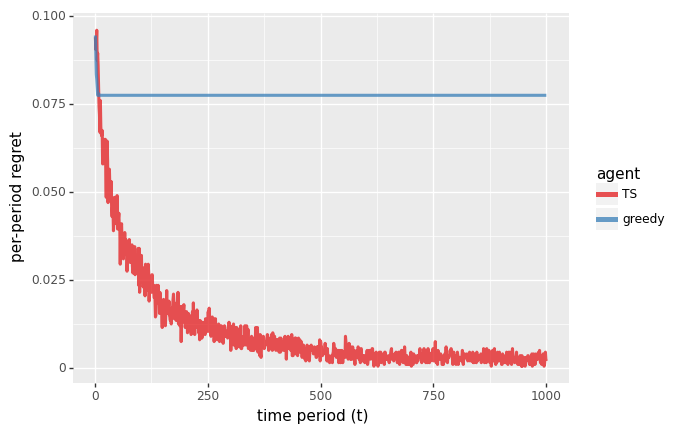

In [10]:
def plotCompara2():
    probs = [0.9,0.8,0.7]
    n_steps = 1000
    N_JOBS = 200

    results1 = []
    for job_id in range(N_JOBS):
        agent = BernoulliBanditTS(n_arm=len(probs))
        env = BernoulliBandit(probs)
        experiment = BaseExperiment(
            agent, env, n_steps=n_steps, seed=job_id, unique_id=str(job_id))
        experiment.run_experiment()
        results1.append(experiment.results)

    df_agent1 = (pd.concat(results1)).assign(agent='TS')

    results2 = []
    for job_id in range(N_JOBS):
        agent = BernoulliBanditEpsilonGreedy(n_arm=len(probs))
        env = BernoulliBandit(probs)
        experiment = BaseExperiment(
            agent, env, n_steps=n_steps, seed=job_id, unique_id=str(job_id))
        experiment.run_experiment()
        results2.append(experiment.results)
    df_agent2 = (pd.concat(results2)).assign(agent='greedy')


    df_agents = pd.concat([df_agent1,df_agent2])

    plt_df = (df_agents.groupby(['t','agent'])
            .agg({'instant_regret': np.mean})
            .reset_index())
    p = (gg.ggplot(plt_df)
       + gg.aes('t', 'instant_regret', colour='agent')
       + gg.geom_line(size=1.25, alpha=0.75)
       + gg.xlab('time period (t)')
       + gg.ylab('per-period regret')
       + gg.scale_colour_brewer(name='agent', type='qual', palette='Set1'))
    print(p)

plotCompara2()

由上图可知，TS的平均悔值随着时间的推移而消失，而贪婪算法则不是这样的。

